In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

! pip install -q pykeen
from pykeen.datasets import Nations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.0/704.0 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00


INFO:pykeen.utils:Using opt_einsum


In [3]:
config = {
    'model_name': 'RotatE',   # options are TransE or RotatE
    'num_entities': 14,
    'num_relations': 55,
    'num_corrupted_head': 64,
    'num_corrupted_tail': 64,
    'hidden_dim': 128,
    'batch_size': 16,
    'num_workers': 2,
    'num_epochs': 100,
    'lr': 2 * 1e-3,
    'gamma': 2.0,
}

In [4]:
dataset = Nations()

num_entities = dataset.num_entities
num_relations = dataset.num_relations

train_triples = dataset.training.mapped_triples
val_triples = dataset.validation.mapped_triples
test_triples = dataset.testing.mapped_triples

print(train_triples)

tensor([[ 0,  3,  2],
        [ 0,  3,  3],
        [ 0,  3, 10],
        ...,
        [13, 54,  9],
        [13, 54, 11],
        [13, 54, 12]])


In [5]:
def generate_negative_relations(positive_relation, all_positive_relations,
                               all_entities_num, eval_only,
                               num_corrupted_tail=None, num_corrupted_head=None):
    head = positive_relation[0]
    rel = positive_relation[1]
    tail = positive_relation[2]

    # find all tails t for which (head, rel, t) is in all_positive_relations
    positive_tails = all_positive_relations[
        torch.bitwise_and(
            all_positive_relations[:, 1] == rel,\
            all_positive_relations[:, 0] == head
        )
    ][:, 2]

    # find all heads h for which (h, rel, tail) is in all_positive_relations
    positive_heads = all_positive_relations[
        torch.bitwise_and(
            all_positive_relations[:, 1] == rel,\
            all_positive_relations[:, 2] == tail
        )
    ][:, 0]

    all_entities = torch.arange(all_entities_num)

    mask_tails = torch.zeros(all_entities_num, dtype=torch.bool)
    mask_tails[positive_tails] = True
    # find all tails t for which (head, rel, t) is NOT in all_positive_relations
    missing_tails = all_entities[~mask_tails]

    mask_heads = torch.zeros(all_entities_num, dtype=torch.bool)
    mask_heads[positive_heads] = True
    # find all heads h for which (h, rel, tail) is NOT in all_positive_relations
    missing_heads = all_entities[~mask_heads]

    # form corrupted relations
    # if eval_only we want all of them triples
    # otherwise we just want a sample of given size
    if eval_only:
        corrupted_tail_data = torch.zeros(missing_tails.shape[0], 3, dtype=torch.int)
        corrupted_tail_data[:, 0:2] = positive_relation[0:2]
        corrupted_tail_data[:, 2] = missing_tails

        corrupted_head_data = torch.zeros(missing_heads.shape[0], 3, dtype=torch.int)
        corrupted_head_data[:, 1:3] = positive_relation[1:3]
        corrupted_head_data[:, 0] = missing_heads

    else:
        # sample (with replacement) from missing_tails and missing_heads
        sampled_tails = missing_tails[
            torch.randint(missing_tails.shape[0], size=(num_corrupted_tail,))
        ]
        sampled_heads = missing_heads[
            torch.randint(missing_heads.shape[0], size=(num_corrupted_head,))
        ]

        corrupted_tail_data = torch.zeros(num_corrupted_tail, 3, dtype=torch.int)
        corrupted_tail_data[:, 0:2] = positive_relation[0:2]
        corrupted_tail_data[:, 2] = sampled_tails

        corrupted_head_data = torch.zeros(num_corrupted_head, 3, dtype=torch.int)
        corrupted_head_data[:, 1:3] = positive_relation[1:3]
        corrupted_head_data[:, 0] = sampled_heads

    return corrupted_tail_data, corrupted_head_data


corrupted_tail_data, corrupted_head_data = generate_negative_relations(
    train_triples[0], train_triples, config['num_entities'], 3, 3
)

print(train_triples[0], end='\n\n')
print(corrupted_tail_data, end='\n\n')
print(corrupted_head_data)

tensor([0, 3, 2])

tensor([[ 0,  3,  0],
        [ 0,  3,  1],
        [ 0,  3,  4],
        [ 0,  3,  5],
        [ 0,  3,  6],
        [ 0,  3,  7],
        [ 0,  3,  8],
        [ 0,  3,  9],
        [ 0,  3, 11],
        [ 0,  3, 12]], dtype=torch.int32)

tensor([[ 1,  3,  2],
        [ 2,  3,  2],
        [ 3,  3,  2],
        [ 4,  3,  2],
        [ 5,  3,  2],
        [ 6,  3,  2],
        [ 7,  3,  2],
        [ 8,  3,  2],
        [10,  3,  2],
        [13,  3,  2]], dtype=torch.int32)


In [19]:
# this dataset takes positive_triples and all_known_positive_triples to be able to
# distinguish between the cases of train, validation and test

# train (train_data, train_data)
# val   (val_data, train_data U val_data)
# test  (test_data, train_data U val_data U test_data)

class CustomDataset(Dataset):
    def __init__(self, positive_triples, all_known_positive_triples, eval_only=False):
        self.positive_triples = positive_triples
        self.all_known_positive_triples = all_known_positive_triples
        self.eval_only = eval_only

    def __len__(self):
        return self.positive_triples.shape[0]

    def __getitem__(self, idx):
        current_triple = self.positive_triples[idx]

        if self.eval_only:
            corrupted_tail_rels, corrupted_head_rels = collect_negative_relations(
                current_triple, self.all_known_positive_triples,
                config['num_entities'], self.eval_only
            )
        else:
            corrupted_tail_rels, corrupted_head_rels = collect_negative_relations(
                current_triple, self.all_known_positive_triples,
                config['num_entities'], self.eval_only,
                config['num_corrupted_tail'], config['num_corrupted_head']
            )

        return current_triple, corrupted_tail_rels, corrupted_head_rels

In [20]:
train_data = CustomDataset(train_triples, train_triples)

val_data = CustomDataset(val_triples,
                         torch.cat([train_triples, val_triples]),
                         eval_only=True)

test_data = CustomDataset(test_triples,
                          torch.cat([train_triples, val_triples, test_triples]),
                          eval_only=True)


train_loader = DataLoader(train_data, batch_size=config['batch_size'],
                          num_workers=config['num_workers'], shuffle=True,
                          drop_last=True)

In [21]:
class RelationScorer(nn.Module):
    def __init__(self, hidden_dim, model_name, num_entities, num_relations):
        super(RelationScorer, self).__init__()

        self.model_name = model_name

        if model_name == 'TransE':
            self.entity_embedder = nn.Embedding(num_entities, hidden_dim)
            self.relation_embedder = nn.Embedding(num_relations, hidden_dim)
        else:
            self.entity_embedder = nn.Embedding(num_entities, 2 * hidden_dim)
            self.relation_embedder = nn.Embedding(num_relations, 2 * hidden_dim)

    def forward(self, x):
        heads = self.entity_embedder(x[:, 0])
        rels = self.relation_embedder(x[:, 1])
        tails = self.entity_embedder(x[:, 2])

        if self.model_name == 'TransE':
            return torch.norm(heads + rels - tails, dim=1)
        elif self.model_name == 'RotatE':
            heads_complex = torch.view_as_complex(heads.view(heads.shape[0], -1, 2))
            rels_complex = torch.view_as_complex(rels.view(rels.shape[0], -1, 2))
            tails_complex = torch.view_as_complex(tails.view(tails.shape[0], -1, 2))

            return torch.norm(heads_complex * rels_complex - tails_complex, dim=1)
        else:
            raise Exception("Invalid Model or Model not Supported.")

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = RelationScorer(
    config['hidden_dim'], config['model_name'],
    config['num_entities'], config['num_relations']
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config['num_epochs'])

In [23]:
train_losses = []; valid_mean_ranks = []

for epoch in range(config['num_epochs']):
    model.train()

    losses = []
    for true_data, corrupted_tail_data, corrupted_head_data in tqdm(train_loader):
        true_data = true_data.to(device)
        false_data = torch.cat([corrupted_tail_data, corrupted_head_data])
        false_data = false_data.to(device)

        optimizer.zero_grad()

        # dissimilarities in true and fake data
        true_data_scores = model(true_data)
        false_data_scores = model(false_data.view(-1, 3)).view(config['batch_size'], -1)

        # loss function components (as in the RotatE paper)
        true_losses = -torch.log(torch.sigmoid(config['gamma'] - true_data_scores))
        false_losses = -torch.mean(torch.log(torch.sigmoid(false_data_scores - config['gamma'])), dim=1)

        loss = torch.mean(true_losses + false_losses)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    # lr_scheduler.step()

    mean_loss = np.mean(losses)
    print(f'Epoch {epoch}:\nTrain Loss:', mean_loss)
    train_losses.append(mean_loss)

    model.eval()

    ranks = []
    for true_data, corrupted_tail_data, corrupted_head_data in val_data:
        true_data = true_data.unsqueeze(0).to(device)
        corrupted_tail_data = corrupted_tail_data.unsqueeze(0).to(device)
        corrupted_head_data = corrupted_head_data.unsqueeze(0).to(device)

        true_data_score = model(true_data)
        corrupted_tail_data_scores = model(corrupted_tail_data.view(-1, 3)).view(1, -1)
        corrupted_head_data_scores = model(corrupted_head_data.view(-1, 3)).view(1, -1)

        rank_corrupted_tail = torch.sum(corrupted_tail_data_scores < true_data_score.item())
        rank_corrupted_head = torch.sum(corrupted_head_data_scores < true_data_score.item())

        rank = (rank_corrupted_tail + rank_corrupted_head) / (corrupted_tail_data_scores.shape[1] + corrupted_head_data_scores.shape[1])
        ranks.append(rank)

        # print(rank_corrupted_tail, rank_corrupted_head,
        #       corrupted_tail_data_scores.shape[1], corrupted_head_data_scores.shape[1])

    mean_rank = np.mean(ranks)
    print(f'Validation Accuracy: {mean_rank}')
    valid_mean_ranks.append(mean_rank)

100%|██████████| 99/99 [00:02<00:00, 35.63it/s]


Epoch 0:
Train Loss: 23.669351269500424
Validation Accuracy: 0.498736709356308


100%|██████████| 99/99 [00:02<00:00, 33.23it/s]


Epoch 1:
Train Loss: 19.997859126389628
Validation Accuracy: 0.48076334595680237


100%|██████████| 99/99 [00:02<00:00, 34.46it/s]


Epoch 2:
Train Loss: 16.803761540037215
Validation Accuracy: 0.4576553702354431


100%|██████████| 99/99 [00:04<00:00, 23.51it/s]


Epoch 3:
Train Loss: 14.020036456560847
Validation Accuracy: 0.4361986219882965


100%|██████████| 99/99 [00:02<00:00, 34.64it/s]


Epoch 4:
Train Loss: 11.57324868019181
Validation Accuracy: 0.4139484167098999


100%|██████████| 99/99 [00:02<00:00, 33.93it/s]


Epoch 5:
Train Loss: 9.42211141489973
Validation Accuracy: 0.405763179063797


100%|██████████| 99/99 [00:02<00:00, 33.94it/s]


Epoch 6:
Train Loss: 7.527578320166077
Validation Accuracy: 0.3948970139026642


100%|██████████| 99/99 [00:04<00:00, 23.60it/s]


Epoch 7:
Train Loss: 5.86727681786123
Validation Accuracy: 0.39225706458091736


100%|██████████| 99/99 [00:02<00:00, 35.16it/s]


Epoch 8:
Train Loss: 4.441942496733232
Validation Accuracy: 0.3896123170852661


100%|██████████| 99/99 [00:03<00:00, 32.16it/s]


Epoch 9:
Train Loss: 3.2755841558629815
Validation Accuracy: 0.38677719235420227


100%|██████████| 99/99 [00:02<00:00, 34.27it/s]


Epoch 10:
Train Loss: 2.4248739914460615
Validation Accuracy: 0.38487428426742554


100%|██████████| 99/99 [00:04<00:00, 24.15it/s]


Epoch 11:
Train Loss: 1.8849120621729378
Validation Accuracy: 0.3837931156158447


100%|██████████| 99/99 [00:02<00:00, 33.15it/s]


Epoch 12:
Train Loss: 1.5934811047833375
Validation Accuracy: 0.37963610887527466


100%|██████████| 99/99 [00:03<00:00, 32.54it/s]


Epoch 13:
Train Loss: 1.4495785284524012
Validation Accuracy: 0.36992526054382324


100%|██████████| 99/99 [00:03<00:00, 31.98it/s]


Epoch 14:
Train Loss: 1.3802592898860122
Validation Accuracy: 0.362804651260376


100%|██████████| 99/99 [00:04<00:00, 23.84it/s]


Epoch 15:
Train Loss: 1.347391016555555
Validation Accuracy: 0.35055679082870483


100%|██████████| 99/99 [00:02<00:00, 35.19it/s]


Epoch 16:
Train Loss: 1.3283129123726276
Validation Accuracy: 0.33603641390800476


100%|██████████| 99/99 [00:02<00:00, 33.91it/s]


Epoch 17:
Train Loss: 1.3155127823954882
Validation Accuracy: 0.329623281955719


100%|██████████| 99/99 [00:03<00:00, 32.54it/s]


Epoch 18:
Train Loss: 1.305233440013847
Validation Accuracy: 0.3263416290283203


100%|██████████| 99/99 [00:04<00:00, 24.70it/s]


Epoch 19:
Train Loss: 1.2971883518527252
Validation Accuracy: 0.32557597756385803


100%|██████████| 99/99 [00:02<00:00, 34.49it/s]


Epoch 20:
Train Loss: 1.2888020734594325
Validation Accuracy: 0.32190290093421936


100%|██████████| 99/99 [00:02<00:00, 35.92it/s]


Epoch 21:
Train Loss: 1.2801876658141012
Validation Accuracy: 0.3227616846561432


100%|██████████| 99/99 [00:03<00:00, 32.83it/s]


Epoch 22:
Train Loss: 1.2737706092873005
Validation Accuracy: 0.3199383020401001


100%|██████████| 99/99 [00:04<00:00, 24.67it/s]


Epoch 23:
Train Loss: 1.2672665998189137
Validation Accuracy: 0.31520795822143555


100%|██████████| 99/99 [00:02<00:00, 33.99it/s]


Epoch 24:
Train Loss: 1.2602732904029614
Validation Accuracy: 0.31510093808174133


100%|██████████| 99/99 [00:02<00:00, 33.01it/s]


Epoch 25:
Train Loss: 1.2534657897371235
Validation Accuracy: 0.31068143248558044


100%|██████████| 99/99 [00:03<00:00, 30.57it/s]


Epoch 26:
Train Loss: 1.2471255148300018
Validation Accuracy: 0.3038337230682373


100%|██████████| 99/99 [00:03<00:00, 24.76it/s]


Epoch 27:
Train Loss: 1.240224920137964
Validation Accuracy: 0.2998024523258209


100%|██████████| 99/99 [00:02<00:00, 35.08it/s]


Epoch 28:
Train Loss: 1.234169724011662
Validation Accuracy: 0.2973173260688782


100%|██████████| 99/99 [00:02<00:00, 34.10it/s]


Epoch 29:
Train Loss: 1.2263062831127283
Validation Accuracy: 0.2937813103199005


100%|██████████| 99/99 [00:03<00:00, 31.80it/s]


Epoch 30:
Train Loss: 1.2194046853768705
Validation Accuracy: 0.28627413511276245


100%|██████████| 99/99 [00:03<00:00, 24.78it/s]


Epoch 31:
Train Loss: 1.212207530484055
Validation Accuracy: 0.2815081477165222


100%|██████████| 99/99 [00:02<00:00, 35.47it/s]


Epoch 32:
Train Loss: 1.2053144568144674
Validation Accuracy: 0.2718845009803772


100%|██████████| 99/99 [00:02<00:00, 36.79it/s]


Epoch 33:
Train Loss: 1.1982394372574006
Validation Accuracy: 0.264174222946167


100%|██████████| 99/99 [00:03<00:00, 31.27it/s]


Epoch 34:
Train Loss: 1.19203897437664
Validation Accuracy: 0.26374906301498413


100%|██████████| 99/99 [00:03<00:00, 25.16it/s]


Epoch 35:
Train Loss: 1.1856154986102172
Validation Accuracy: 0.26146307587623596


100%|██████████| 99/99 [00:02<00:00, 36.00it/s]


Epoch 36:
Train Loss: 1.180033727125688
Validation Accuracy: 0.2566985785961151


100%|██████████| 99/99 [00:02<00:00, 34.27it/s]


Epoch 37:
Train Loss: 1.1742231845855713
Validation Accuracy: 0.2527514398097992


100%|██████████| 99/99 [00:02<00:00, 33.16it/s]


Epoch 38:
Train Loss: 1.1695109954988114
Validation Accuracy: 0.2540309727191925


100%|██████████| 99/99 [00:03<00:00, 25.03it/s]


Epoch 39:
Train Loss: 1.1632765615829315
Validation Accuracy: 0.24897056818008423


100%|██████████| 99/99 [00:02<00:00, 36.22it/s]


Epoch 40:
Train Loss: 1.1589097880353831
Validation Accuracy: 0.247223362326622


100%|██████████| 99/99 [00:02<00:00, 34.35it/s]


Epoch 41:
Train Loss: 1.1537679758938877
Validation Accuracy: 0.24021144211292267


100%|██████████| 99/99 [00:02<00:00, 34.85it/s]


Epoch 42:
Train Loss: 1.1502099855981691
Validation Accuracy: 0.2371251881122589


100%|██████████| 99/99 [00:04<00:00, 23.43it/s]


Epoch 43:
Train Loss: 1.144876120066402
Validation Accuracy: 0.23702393472194672


100%|██████████| 99/99 [00:02<00:00, 33.44it/s]


Epoch 44:
Train Loss: 1.141941245156105
Validation Accuracy: 0.23752158880233765


100%|██████████| 99/99 [00:03<00:00, 32.98it/s]


Epoch 45:
Train Loss: 1.1383518365898517
Validation Accuracy: 0.23709887266159058


100%|██████████| 99/99 [00:04<00:00, 20.91it/s]


Epoch 46:
Train Loss: 1.1359750164879694
Validation Accuracy: 0.23660588264465332


100%|██████████| 99/99 [00:04<00:00, 24.69it/s]


Epoch 47:
Train Loss: 1.131666873440598
Validation Accuracy: 0.23218148946762085


100%|██████████| 99/99 [00:02<00:00, 34.88it/s]


Epoch 48:
Train Loss: 1.129346984805483
Validation Accuracy: 0.22993777692317963


100%|██████████| 99/99 [00:02<00:00, 33.70it/s]


Epoch 49:
Train Loss: 1.1268169843789302
Validation Accuracy: 0.2310734987258911


100%|██████████| 99/99 [00:03<00:00, 31.08it/s]


Epoch 50:
Train Loss: 1.1241784312508323
Validation Accuracy: 0.2277110069990158


100%|██████████| 99/99 [00:03<00:00, 25.43it/s]


Epoch 51:
Train Loss: 1.1205115227988272
Validation Accuracy: 0.23183555901050568


100%|██████████| 99/99 [00:02<00:00, 33.12it/s]


Epoch 52:
Train Loss: 1.1190133100808268
Validation Accuracy: 0.2308674305677414


100%|██████████| 99/99 [00:02<00:00, 33.50it/s]


Epoch 53:
Train Loss: 1.1175919241375394
Validation Accuracy: 0.2298542559146881


100%|██████████| 99/99 [00:03<00:00, 30.26it/s]


Epoch 54:
Train Loss: 1.1151352566902084
Validation Accuracy: 0.22866438329219818


100%|██████████| 99/99 [00:03<00:00, 26.99it/s]


Epoch 55:
Train Loss: 1.1135988434155781
Validation Accuracy: 0.22922630608081818


100%|██████████| 99/99 [00:02<00:00, 33.85it/s]


Epoch 56:
Train Loss: 1.11114163832231
Validation Accuracy: 0.22841109335422516


100%|██████████| 99/99 [00:02<00:00, 33.63it/s]


Epoch 57:
Train Loss: 1.109295524732031
Validation Accuracy: 0.23188762366771698


100%|██████████| 99/99 [00:03<00:00, 28.62it/s]


Epoch 58:
Train Loss: 1.1082961517150955
Validation Accuracy: 0.23064875602722168


100%|██████████| 99/99 [00:04<00:00, 24.71it/s]


Epoch 59:
Train Loss: 1.105595001066574
Validation Accuracy: 0.23060953617095947


100%|██████████| 99/99 [00:03<00:00, 32.23it/s]


Epoch 60:
Train Loss: 1.1046381719184644
Validation Accuracy: 0.23071250319480896


100%|██████████| 99/99 [00:02<00:00, 33.29it/s]


Epoch 61:
Train Loss: 1.10278960610881
Validation Accuracy: 0.23065634071826935


100%|██████████| 99/99 [00:03<00:00, 24.76it/s]


Epoch 62:
Train Loss: 1.1009813372534936
Validation Accuracy: 0.23288995027542114


100%|██████████| 99/99 [00:03<00:00, 29.66it/s]


Epoch 63:
Train Loss: 1.1006619984453374
Validation Accuracy: 0.2305569052696228


100%|██████████| 99/99 [00:03<00:00, 32.07it/s]


Epoch 64:
Train Loss: 1.0992107018075807
Validation Accuracy: 0.22988565266132355


100%|██████████| 99/99 [00:03<00:00, 32.64it/s]


Epoch 65:
Train Loss: 1.0982199124615601
Validation Accuracy: 0.23008210957050323


100%|██████████| 99/99 [00:04<00:00, 22.64it/s]


Epoch 66:
Train Loss: 1.0971590057768004
Validation Accuracy: 0.2314363420009613


100%|██████████| 99/99 [00:03<00:00, 32.42it/s]


Epoch 67:
Train Loss: 1.0947788670809582
Validation Accuracy: 0.2285037785768509


100%|██████████| 99/99 [00:03<00:00, 30.60it/s]


Epoch 68:
Train Loss: 1.0946169104238954
Validation Accuracy: 0.22947868704795837


100%|██████████| 99/99 [00:03<00:00, 29.49it/s]


Epoch 69:
Train Loss: 1.0927004230142845
Validation Accuracy: 0.23015053570270538


100%|██████████| 99/99 [00:04<00:00, 22.93it/s]


Epoch 70:
Train Loss: 1.0916208317785552
Validation Accuracy: 0.22953926026821136


100%|██████████| 99/99 [00:03<00:00, 30.57it/s]


Epoch 71:
Train Loss: 1.0904735272580928
Validation Accuracy: 0.22823943197727203


100%|██████████| 99/99 [00:03<00:00, 30.03it/s]


Epoch 72:
Train Loss: 1.0901502214296899
Validation Accuracy: 0.22727973759174347


100%|██████████| 99/99 [00:04<00:00, 23.85it/s]


Epoch 73:
Train Loss: 1.089928640861704
Validation Accuracy: 0.22810915112495422


100%|██████████| 99/99 [00:03<00:00, 30.26it/s]


Epoch 74:
Train Loss: 1.0882488398840933
Validation Accuracy: 0.22825059294700623


100%|██████████| 99/99 [00:03<00:00, 28.11it/s]


Epoch 75:
Train Loss: 1.0863655221582664
Validation Accuracy: 0.22819101810455322


100%|██████████| 99/99 [00:04<00:00, 23.47it/s]


Epoch 76:
Train Loss: 1.0874851996248418
Validation Accuracy: 0.22637954354286194


100%|██████████| 99/99 [00:04<00:00, 22.02it/s]


Epoch 77:
Train Loss: 1.085459266046081
Validation Accuracy: 0.22616703808307648


100%|██████████| 99/99 [00:04<00:00, 24.51it/s]


Epoch 78:
Train Loss: 1.0856100507456847
Validation Accuracy: 0.22689604759216309


100%|██████████| 99/99 [00:04<00:00, 22.45it/s]


Epoch 79:
Train Loss: 1.0845278116187664
Validation Accuracy: 0.22599506378173828


100%|██████████| 99/99 [00:05<00:00, 18.88it/s]


Epoch 80:
Train Loss: 1.0839442996063617
Validation Accuracy: 0.22576352953910828


100%|██████████| 99/99 [00:05<00:00, 17.87it/s]


Epoch 81:
Train Loss: 1.0837992122679045
Validation Accuracy: 0.2258036881685257


100%|██████████| 99/99 [00:06<00:00, 16.43it/s]


Epoch 82:
Train Loss: 1.083107919404001
Validation Accuracy: 0.2255055457353592


100%|██████████| 99/99 [00:04<00:00, 23.53it/s]


Epoch 83:
Train Loss: 1.0818145118578515
Validation Accuracy: 0.22478808462619781


100%|██████████| 99/99 [00:04<00:00, 23.97it/s]


Epoch 84:
Train Loss: 1.0817112392849393
Validation Accuracy: 0.22516310214996338


100%|██████████| 99/99 [00:05<00:00, 18.76it/s]


Epoch 85:
Train Loss: 1.0807765342972495
Validation Accuracy: 0.22576765716075897


100%|██████████| 99/99 [00:04<00:00, 24.10it/s]


Epoch 86:
Train Loss: 1.0801555893637917
Validation Accuracy: 0.2269175797700882


100%|██████████| 99/99 [00:04<00:00, 24.01it/s]


Epoch 87:
Train Loss: 1.0802790209500477
Validation Accuracy: 0.2254527062177658


100%|██████████| 99/99 [00:04<00:00, 20.82it/s]


Epoch 88:
Train Loss: 1.078503071057676
Validation Accuracy: 0.22492463886737823


100%|██████████| 99/99 [00:04<00:00, 24.03it/s]


Epoch 89:
Train Loss: 1.0785494049390156
Validation Accuracy: 0.22751742601394653


100%|██████████| 99/99 [00:04<00:00, 21.66it/s]


Epoch 90:
Train Loss: 1.0772618350356515
Validation Accuracy: 0.22614510357379913


100%|██████████| 99/99 [00:05<00:00, 18.63it/s]


Epoch 91:
Train Loss: 1.0784266205749127
Validation Accuracy: 0.22422590851783752


100%|██████████| 99/99 [00:04<00:00, 22.89it/s]


Epoch 92:
Train Loss: 1.0781540973017913
Validation Accuracy: 0.2255629301071167


100%|██████████| 99/99 [00:05<00:00, 19.53it/s]


Epoch 93:
Train Loss: 1.0742821097373962
Validation Accuracy: 0.22504281997680664


100%|██████████| 99/99 [00:04<00:00, 20.37it/s]


Epoch 94:
Train Loss: 1.0750915522527213
Validation Accuracy: 0.22516170144081116


100%|██████████| 99/99 [00:04<00:00, 22.46it/s]


Epoch 95:
Train Loss: 1.0751801596747503
Validation Accuracy: 0.2254915088415146


100%|██████████| 99/99 [00:05<00:00, 18.14it/s]


Epoch 96:
Train Loss: 1.076656612482938
Validation Accuracy: 0.22616040706634521


100%|██████████| 99/99 [00:05<00:00, 19.01it/s]


Epoch 97:
Train Loss: 1.0748549651617956
Validation Accuracy: 0.2248421311378479


100%|██████████| 99/99 [00:04<00:00, 22.52it/s]


Epoch 98:
Train Loss: 1.0742723098909013
Validation Accuracy: 0.22758829593658447


100%|██████████| 99/99 [00:05<00:00, 18.33it/s]


Epoch 99:
Train Loss: 1.0738350574416344
Validation Accuracy: 0.22546067833900452


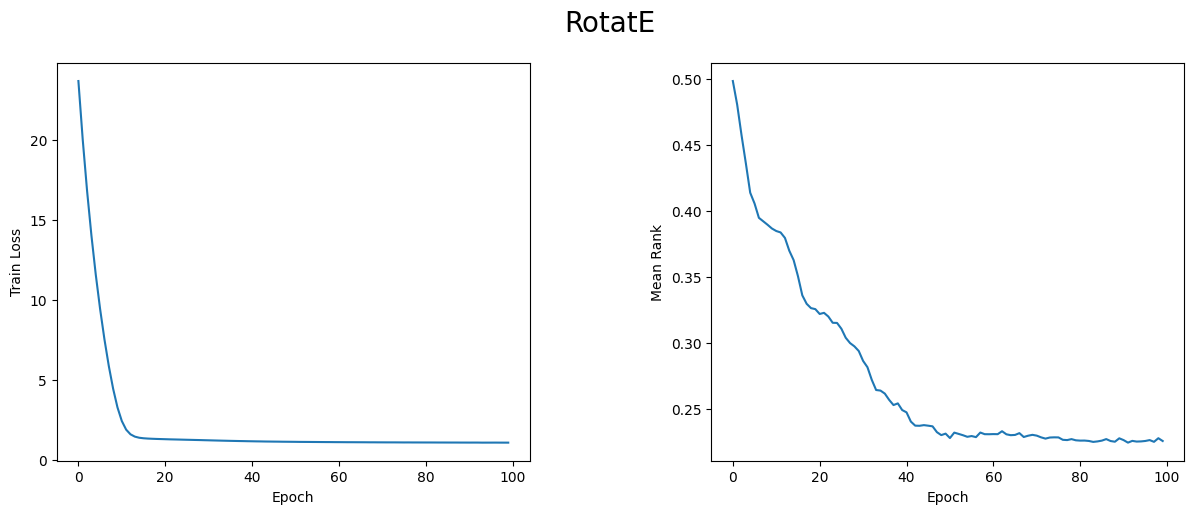

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(config['model_name'], fontsize=20)
fig.tight_layout(w_pad=10.0)

axs[0].plot(train_losses, label='Training Losses')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Train Loss")

axs[1].plot(valid_mean_ranks, label='Validation Metrics - Mean Rank')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Mean Rank")

plt.show()